In [1]:
# install libraries
import influxdb_client
import pandas as pd
import secret
from sensor_data_functions import get_sensor_data
from weather_data_functions import get_current_weather, get_historical_weather
from irradiance_data_functions import irradiance_data
import matplotlib.pyplot as plt
import requests
from datetime import datetime

In [2]:
lookback = '12h'
generation_df, consumption_df = get_sensor_data(lookback)
generation_df.head()

,power
datetime,
2023-12-21 09:29:33+00:00,0.587934
2023-12-21 09:29:34+00:00,0.602368
2023-12-21 09:29:35+00:00,0.592422
2023-12-21 09:29:36+00:00,0.593342
2023-12-21 09:29:37+00:00,0.598589


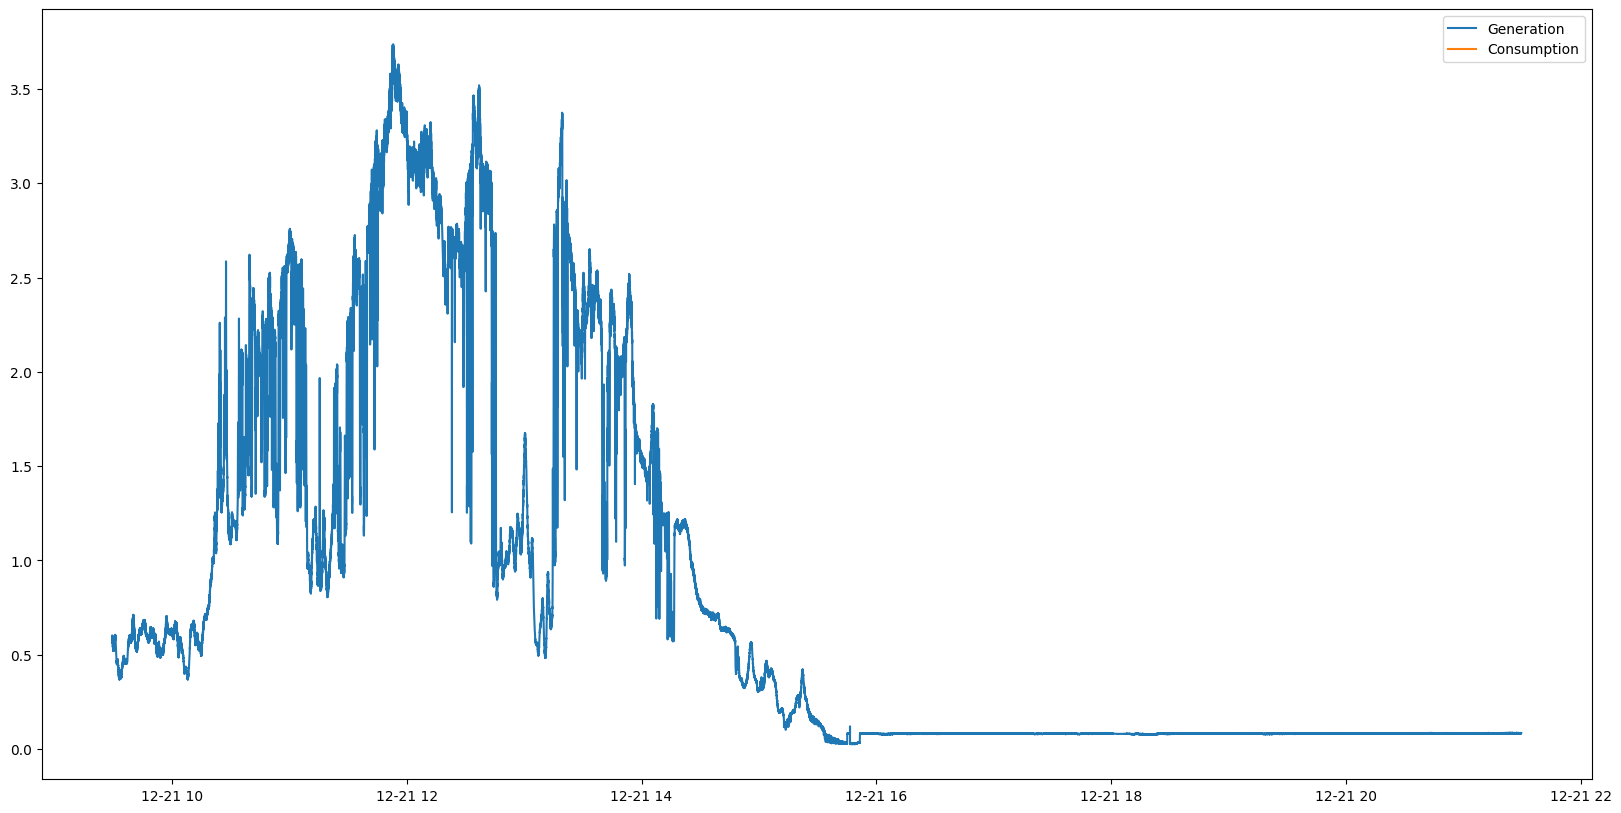

In [3]:
# plot both generation and consumption
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(generation_df.index, generation_df['power'], label='Generation')
ax.plot(consumption_df.index, consumption_df['power'], label='Consumption')
ax.legend()

In [4]:
postcode = 'WR7 4BU'
current_weather = get_current_weather(postcode)
current_weather

,last_updated_epoch,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,...,humidity,cloud,feelslike_c,feelslike_f,vis_km,vis_miles,uv,gust_mph,gust_kph,condition
last_updated,,,,,,,,,,,,,,,,,,,,,
2023-12-21 21:15,1703193300,11.0,51.8,0,16.1,25.9,300,WNW,1011.0,29.85,...,58,75,7.8,46.1,10.0,6.0,1.0,29.6,47.7,Partly cloudy


In [5]:
postcode = 'WR7 4BU'
date_time = datetime(year=2023, month=12, day=21)

weather = get_historical_weather(postcode, date_time)
weather.head()

,time_epoch,temp_c,temp_f,is_day,wind_mph,wind_kph,wind_degree,wind_dir,pressure_mb,pressure_in,...,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,uv,condition
time,,,,,,,,,,,,,,,,,,,,,
2023-12-21 00:00,1703116800,10.2,50.4,0,18.6,29.9,275,W,1013.0,29.91,...,0,45,0,0,10.0,6.0,27.9,44.9,1.0,Patchy rain possible
2023-12-21 01:00,1703120400,10.2,50.4,0,18.1,29.2,269,W,1012.0,29.88,...,0,45,0,0,10.0,6.0,27.6,44.5,1.0,Patchy rain possible
2023-12-21 02:00,1703124000,10.3,50.5,0,17.9,28.8,272,W,1011.0,29.86,...,0,45,0,0,10.0,6.0,27.0,43.5,1.0,Patchy rain possible
2023-12-21 03:00,1703127600,10.3,50.5,0,19.0,30.6,273,W,1011.0,29.86,...,0,45,0,0,10.0,6.0,28.5,45.8,1.0,Patchy rain possible
2023-12-21 04:00,1703131200,10.5,50.9,0,21.0,33.8,272,W,1010.0,29.83,...,0,0,0,0,10.0,6.0,31.0,50.0,1.0,Overcast


In [7]:
postcode = 'WR7 4BU'
irradiance_data(postcode, date_time)

Locally available data used


,start,end,clear_sky,cloudy_sky,start_time
0,00:00,00:15,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-21 00:00:00
1,00:15,00:30,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-21 00:15:00
2,00:30,00:45,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-21 00:30:00
3,00:45,01:00,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-21 00:45:00
4,01:00,01:15,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-21 01:00:00
...,...,...,...,...,...
91,22:45,23:00,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-21 22:45:00
92,23:00,23:15,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-21 23:00:00
93,23:15,23:30,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-21 23:15:00
94,23:30,23:45,"{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}","{'ghi': 0.0, 'dni': 0.0, 'dhi': 0.0}",2023-12-21 23:30:00
